# Clustering Methods

In [17]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import polars.selectors as ps

from scipy.cluster import hierarchy

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression

We'll use the Wine quality dataset again. This time I chose to start using polars instead of pandas to start learning how the library works. We'll do some EDA on the data:
- Examine features
- Note continuous, categorical, boolean
- How many entries for each colr and for the range of quality options
- Histogram of the quality for each color

In [2]:
df = pl.read_csv("./data/Wine_Quality_Data.csv")
df.head(4)

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str
7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,"""red"""
7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8,5,"""red"""
7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5,"""red"""
11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6,"""red"""


The basic dataset characteristics are:
- 13 columns
    - 11 float
    - 1 int
    - 1 string
- 6497 datapoints

In [3]:
df.shape

(6497, 13)

In [4]:
dict(zip(df.columns, df.dtypes))

{'fixed_acidity': Float64,
 'volatile_acidity': Float64,
 'citric_acid': Float64,
 'residual_sugar': Float64,
 'chlorides': Float64,
 'free_sulfur_dioxide': Float64,
 'total_sulfur_dioxide': Float64,
 'density': Float64,
 'pH': Float64,
 'sulphates': Float64,
 'alcohol': Float64,
 'quality': Int64,
 'color': String}

Getting started with polars is a bit of a challenge, many of the methods I used before don't work (like easily transposing the describe results). Simply transposing in Polars is an option, but due to datatype conversions and the lack of an index, this is not working properly. Below is an equivalent construction:

In [5]:
(
    df.select(ps.numeric()).describe().filter(~pl.col("statistic").is_in(["count", "25%", "75%"]))
      .unpivot(index="statistic", variable_name="column", value_name="value")
      .pivot(
          values="value",
          index="column",
          on="statistic"
      )
).show(None)

column,null_count,mean,std,min,50%,max
str,f64,f64,f64,f64,f64,f64
"""fixed_acidity""",0.0,7.215307,1.296434,3.8,7.0,15.9
"""volatile_acidity""",0.0,0.339666,0.164636,0.08,0.29,1.58
"""citric_acid""",0.0,0.318633,0.145318,0.0,0.31,1.66
"""residual_sugar""",0.0,5.443235,4.757804,0.6,3.0,65.8
"""chlorides""",0.0,0.056034,0.035034,0.009,0.047,0.611
"""free_sulfur_dioxide""",0.0,30.525319,17.7494,1.0,29.0,289.0
"""total_sulfur_dioxide""",0.0,115.744574,56.521855,6.0,118.0,440.0
"""density""",0.0,0.994697,0.002999,0.98711,0.99489,1.03898
"""pH""",0.0,3.218501,0.160787,2.72,3.21,4.01


Now we know the approximate distribution of the numeric values we can check how representative the classes are.

In [6]:
(
    df.group_by("color")
    .len()
    .rename({'len': 'count'})
    .sort('count', descending=True)
)

color,count
str,u32
"""white""",4898
"""red""",1599


In [7]:
(
    df.group_by("quality")
    .len()
    .rename({'len': 'count'})
    .sort('quality', descending=True)
)

quality,count
i64,u32
9,5
8,193
7,1079
6,2836
5,2138
4,216
3,30


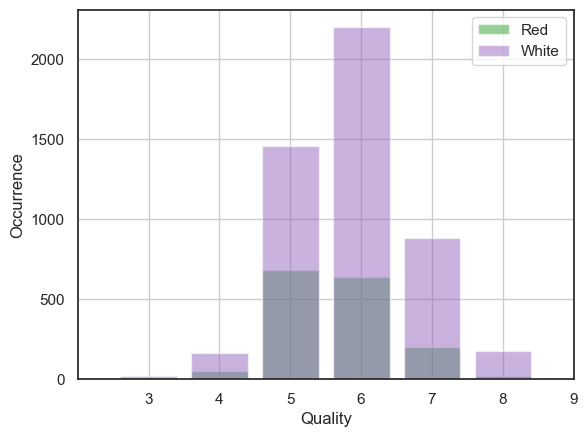

In [8]:
grouped_df = df.select(pl.col(['color', 'quality'])).group_by(["color", "quality"]).len().rename({"len": "n"})

grouped_df = grouped_df.pivot(
    values="n",
    index="quality",
    on="color"
).fill_null(0)

qualities = grouped_df['quality']
red_counts = grouped_df['red']
white_counts = grouped_df['white']

sns.set_context('notebook')
sns.set_style('white')

red = sns.color_palette()[2]
white = sns.color_palette()[4]

ax = plt.axes()
ax.bar(qualities, red_counts, label="Red", color=red, alpha=0.5)
ax.bar(qualities, white_counts, label="White", color=white, alpha=0.5)
ax.set(xlabel='Quality', ylabel='Occurrence')

# force tick labels to be in middle of region
ax.set_xlim(2,9)
ax.set_xticks(np.array([3, 4, 5, 6, 7, 8, 9]))
ax.set_xticklabels(np.array([3, 4, 5, 6, 7, 8, 9]))
ax.grid('off')
ax.legend();

From this it is clear that the ratio of the classes is very uneven. Also, the wines seem to be concentrated around the middle values (mostly 5, 6 and 7). Not many wines are classified are extremely good or extremely bad. By plotting the counts per category combination, we can see that there are 0 red wines classified as category 9, and only 5 white wines.

In [9]:
grouped_df

quality,white,red
i64,u32,u32
8,175,18
9,5,0
3,20,10
7,880,199
4,163,53
5,1457,681
6,2198,638


## Correlation and Skew

Let's do some more EDA with polars. We'll explore skew and the correlation bewteen variables.

For this we'll ignore the categorical variables.

In [10]:
corr = (
    df
    # Select only numeric values
    .select(ps.numeric())
    # Calculate correlation matrix
    .corr()
    # Pipe correlation amtrix for further processing
    .pipe(
        lambda c: 
            # Replace the diagonal values with 0.0
            c.with_columns([
                pl.when(pl.arange(0, c.height) == i)
                .then(0.0)
                .otherwise(pl.col(col))
                .alias(col)
            for i, col in enumerate(c.columns)
            ])
    )
)

max_corr_idx = (
    corr
    # Find the index of the maximum value for each column
    .with_columns(pl.all().abs().arg_max())
    # Only keep one copy (resulting df still has dimension (n_cols x n_cols))
    .row(0)
)

res = {"feat_1": [], "feat_2":[], "correlation": []}
for feat, idx in zip(corr.columns, max_corr_idx):
#    for col in df.columns:
    res["feat_1"].append(feat)
    res["feat_2"].append(corr.columns[idx])
    res["correlation"].append(corr[feat][idx])

largest_correlations = pl.DataFrame(res)

largest_correlations.sort(by="correlation").show(None)

feat_1,feat_2,correlation
str,str,f64
"""alcohol""","""density""",-0.686745
"""density""","""alcohol""",-0.686745
"""volatile_acidity""","""total_sulfur_dioxide""",-0.414476
"""citric_acid""","""volatile_acidity""",-0.377981
"""pH""","""citric_acid""",-0.329808
"""chlorides""","""sulphates""",0.395593
"""sulphates""","""chlorides""",0.395593
"""quality""","""alcohol""",0.444319
"""fixed_acidity""","""density""",0.45891


In [11]:
skew_values = (
    df
    .select(ps.numeric())
    .select(pl.all().skew())
    .transpose(include_header=True)
    .rename({'column': 'feature', 'column_0': 'skew_value'})
    .filter(pl.col('skew_value') > 0.75)
    .sort('skew_value', descending=True)
)

skew_values

feature,skew_value
str,f64
"""chlorides""",5.398581
"""sulphates""",1.796855
"""fixed_acidity""",1.722892
"""volatile_acidity""",1.494751
"""residual_sugar""",1.435073
"""free_sulfur_dioxide""",1.219784


With quite a few variables skewed, we can perform a log transform to correct this.

In [12]:
df_unskewed = (
    df
    .with_columns([
        pl.col(col).log1p()
        for col in skew_values['feature']
    ])
)

Finally, we can use the standard scaler fo transform our data

In [13]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
float_columns = df_unskewed.select(ps.float()).columns
to_scale = df_unskewed.select(ps.float()).to_numpy()
scaled = sc.fit_transform(to_scale)

df_scaled = df_unskewed.with_columns([
    pl.Series(col, scaled[:, i])
    for i, col in enumerate(float_columns)
])

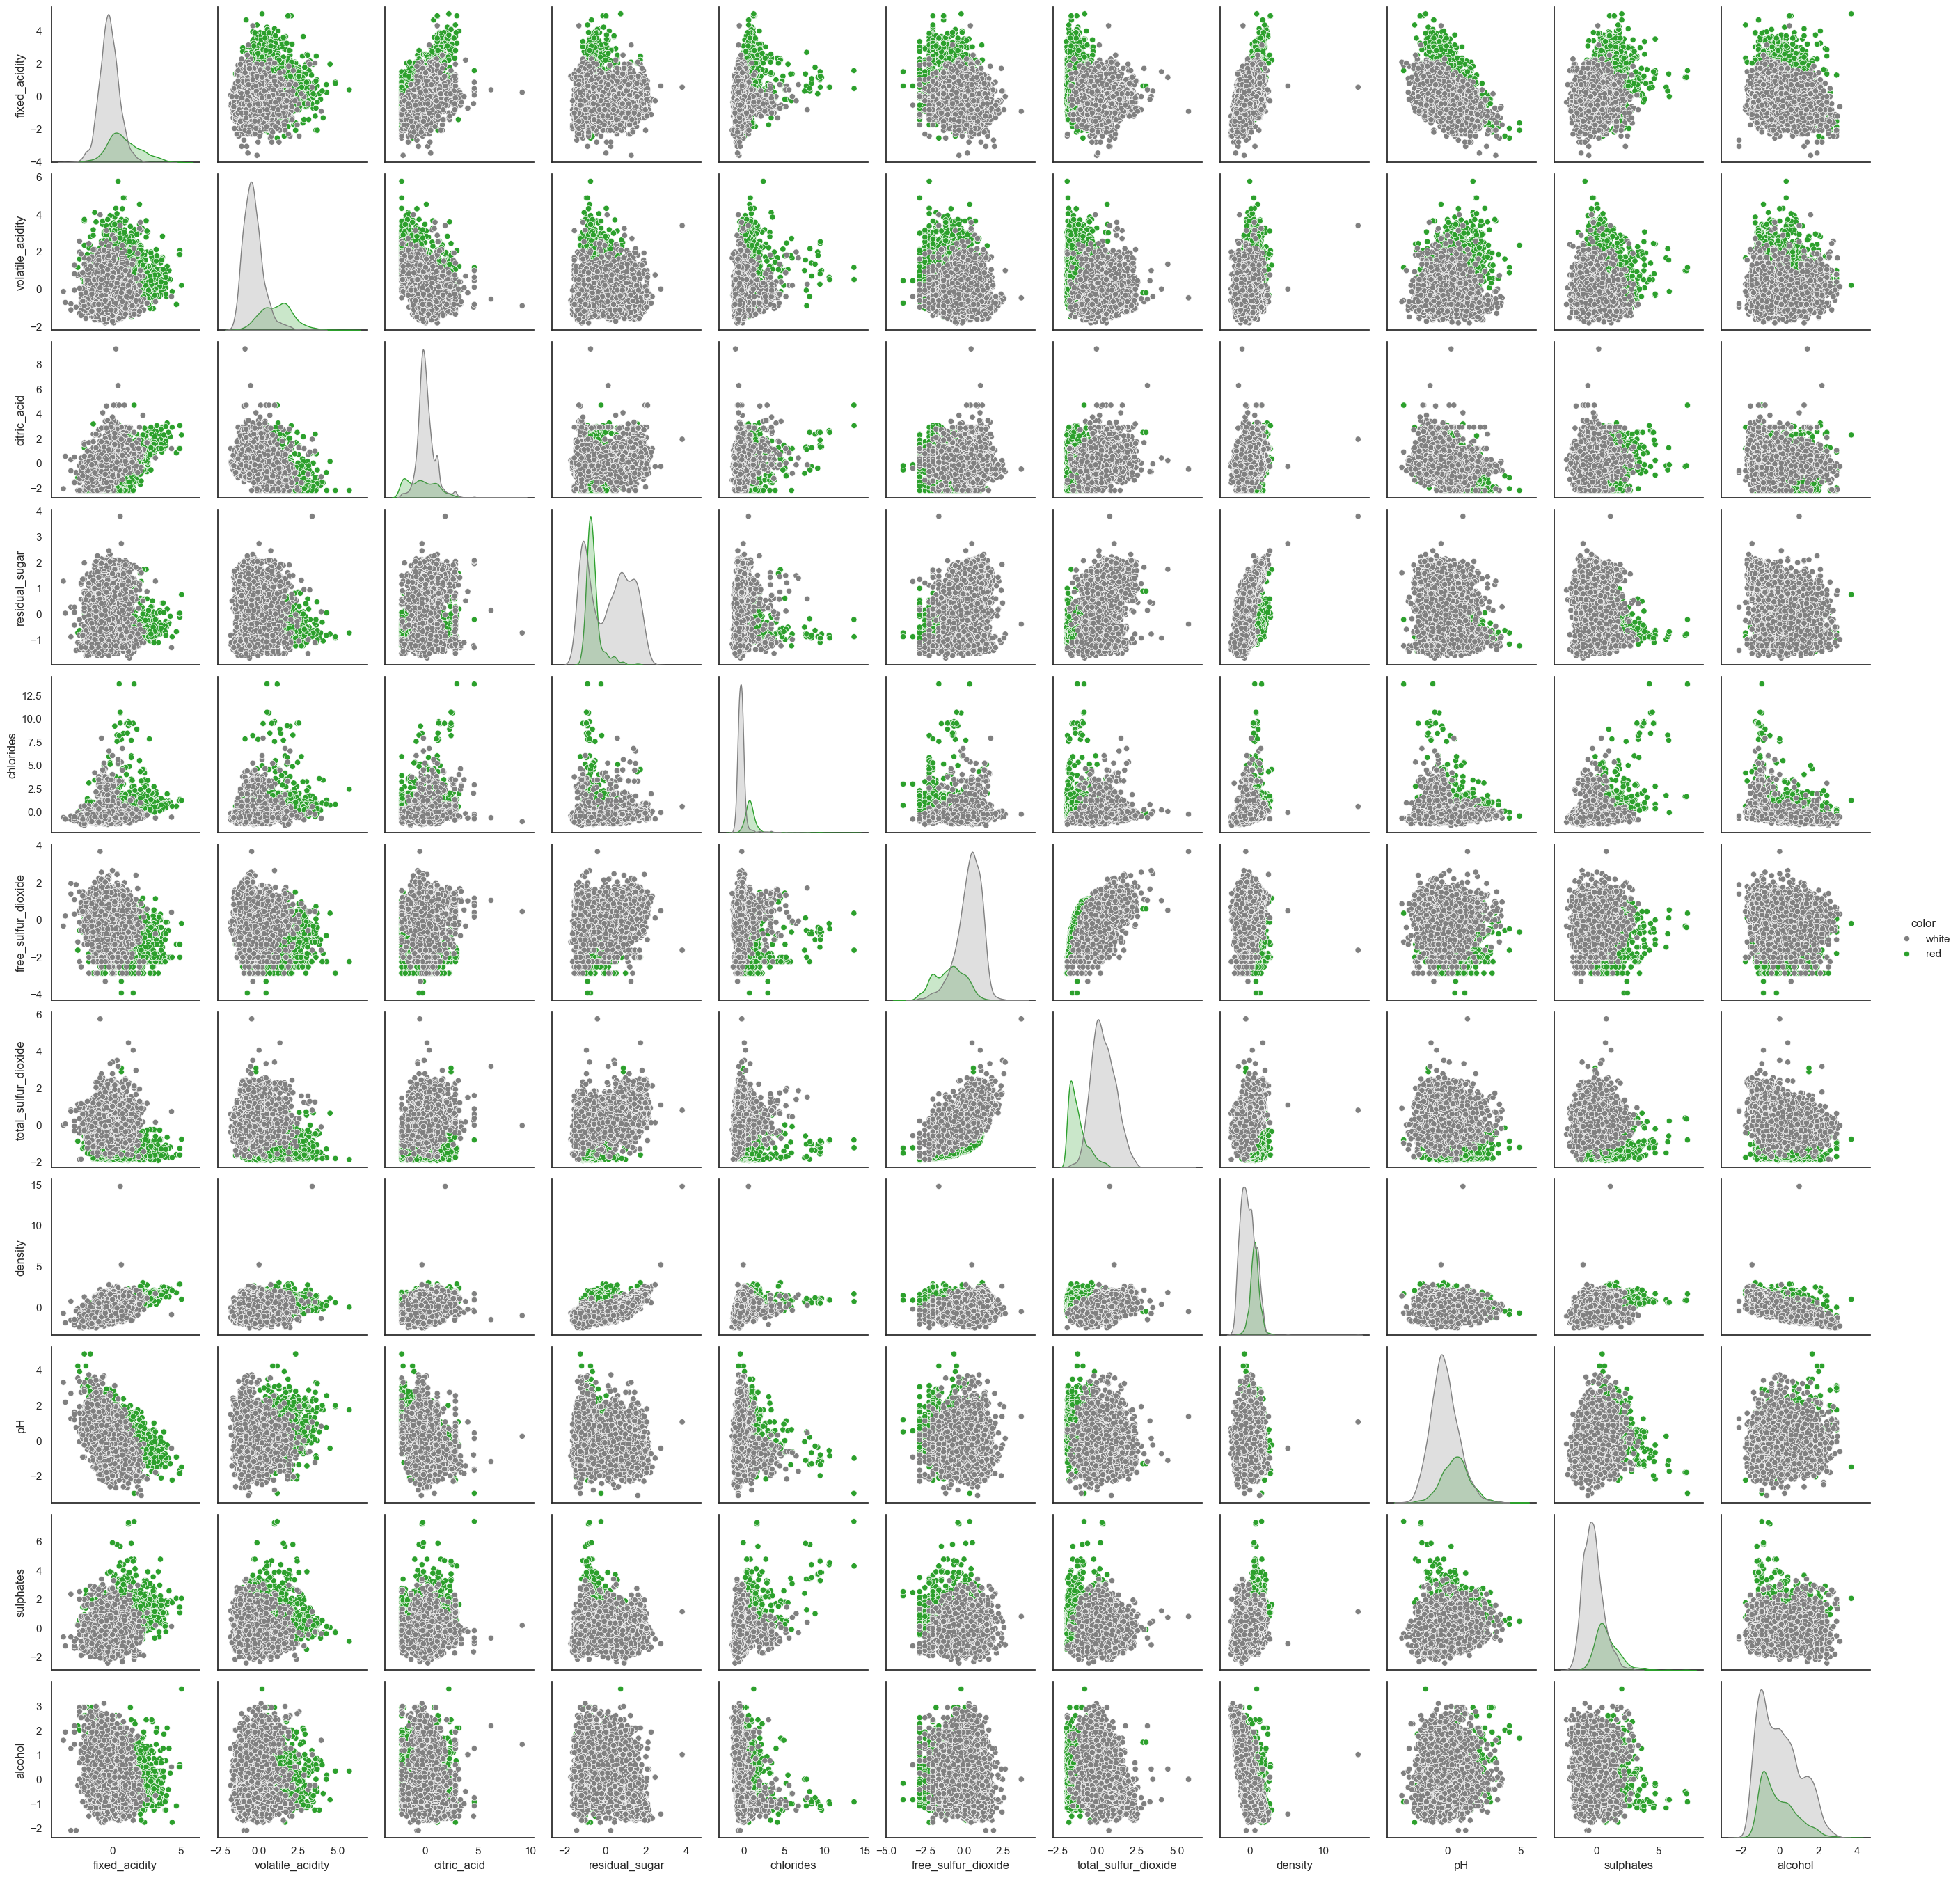

In [14]:
sns.set_context('notebook')
sns.pairplot(df_scaled[float_columns + ['color']].to_pandas(), 
             hue='color', 
             hue_order=['white', 'red'],
             palette={'red':red, 'white':'gray'});

## Fitting a Kmeans Cluster

We can fit a 2-cluster KMeans model easily. Then we assign the result of the clustering back into the dataframe and then group and sort by the color and found cluster.

In [22]:
X = df_scaled

km = KMeans(n_clusters=2, random_state=42)
km.fit(X.select(ps.float()))

,n_clusters,2
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [24]:
X_res = (
    X
    .with_columns(
        pl.Series(
            "kmeans", 
            km.predict(X.select(ps.float()))
        )
    )
)

In [29]:
(
    X_res
    .select(['color', 'kmeans'])
    .group_by(['kmeans', 'color'])
    .len()
    .sort(by=['kmeans', 'color'])
)

kmeans,color,len
i32,str,u32
0,"""red""",1576
0,"""white""",87
1,"""red""",23
1,"""white""",4811


## Finding the best value of K

Just 2 clusters is probably not the best number for our data, so let's investigate the dependence of the fit quality on K.

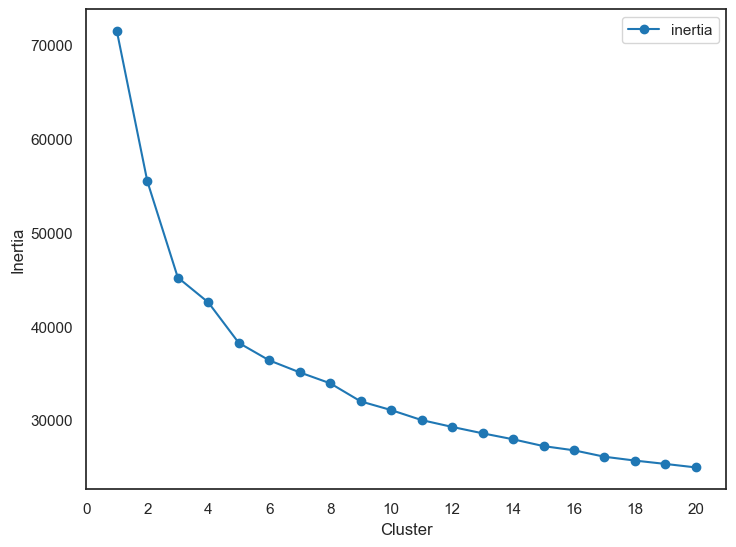

In [41]:
km_res = []

for k in range(1, 21):
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(X.select(ps.float()))
    
    km_res.append(
        pl.DataFrame({'clusters': k, 'inertia': km.inertia_})
    )

plot_data = (
    pl.concat(km_res)
)

fig = plt.figure()
ax = fig.add_axes((0, 0, 1, 1))
ax.plot(plot_data['clusters'], plot_data['inertia'], 'o-', label='inertia')
ax.set_xticks(range(0,21,2))
ax.set_xlim(0,21)
ax.set(xlabel='Cluster', ylabel='Inertia')
ax.legend();

There is no clear point where the elbow method would recommend a best K. However, the inertia is going down with the amount of clusters. It seems that choosing K in the range of 6-14 would work best in this case.

But mostly, it seems that KMeans is not capable of finding a good K for this dataset. Let's try with a few different clustering methods.

## Agglomerative Clustering

With agglomerative clustering we start at a relatively large number of clusters and keep combining clusters that lie close to each other until their size is above a certain threshold.

In [43]:
ag = AgglomerativeClustering(n_clusters=2, linkage='ward', compute_full_tree=True)
ag.fit(X.select(ps.float()))
X_res = (
    X_res
    .with_columns(
        pl.Series(
            "agglom", 
            ag.fit_predict(X.select(ps.float()))
        )
    )
)

We can compare the result of the clustering to the KMeans result from before

In [44]:
(
    X_res
    .select(['color', 'agglom'])
    .group_by(['agglom', 'color'])
    .len()
    .sort(by=['agglom', 'color'])
)

agglom,color,len
i64,str,u32
0,"""red""",31
0,"""white""",4755
1,"""red""",1568
1,"""white""",143


In [45]:
(
    X_res
    .select(['color', 'kmeans'])
    .group_by(['kmeans', 'color'])
    .len()
    .sort(by=['kmeans', 'color'])
)

kmeans,color,len
i32,str,u32
0,"""red""",1576
0,"""white""",87
1,"""red""",23
1,"""white""",4811


Though the numbering of the clusters is different (expected since the initialisation of the clusters is random), the results are very consistent for 2 clusters when comparing between color variants.

Since agglomerative clustering works like a tree that iteratively gets build up until each branch is above a threshold, we can visualize it with a dendrogram.

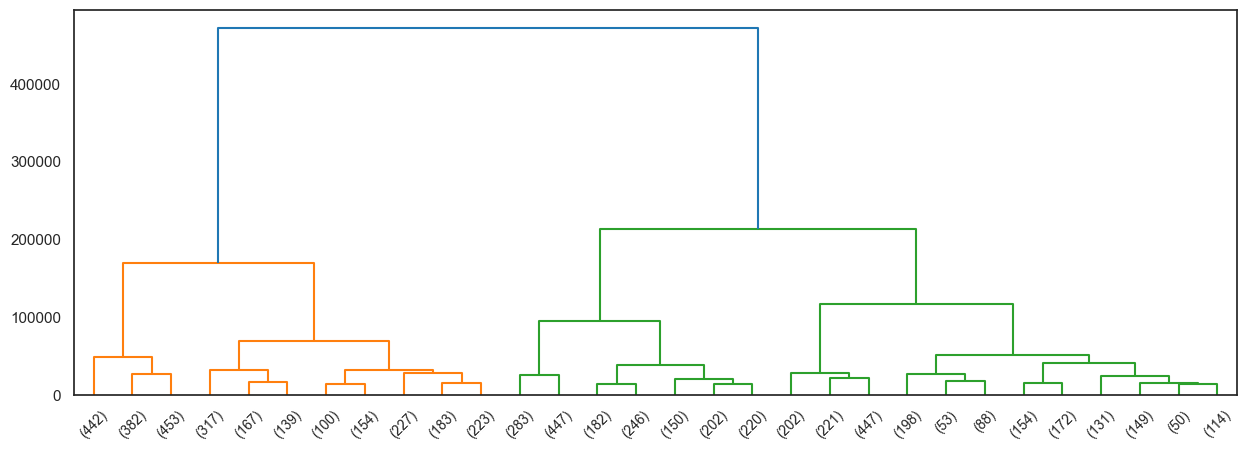

In [46]:
Z = hierarchy.linkage(ag.children_, method='ward')

fig, ax = plt.subplots(figsize=(15,5))

den = hierarchy.dendrogram(Z, orientation='top', 
                           p=30, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax)

## Clustering as Feature Engineering

*   Create a **binary** target variable `y`, denoting if the quality is greater than 7 or not.
*   Create a variable called `X_with_kmeans` from `data`, by dropping the columns "quality", "color" and "agglom" from the dataset. Create `X_without_kmeans` from that by dropping "kmeans".
*   For both datasets, using **[StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2022-01-01)** with 10 splits, fit 10 Random Forest Classifiers and find the mean of the ROC-AUC scores from these 10 classifiers.
*   Compare the average roc-auc scores for both models, the one using the KMeans cluster as a feature and the one that doesn't use it.

In [65]:
y = X.select(pl.col('quality') > 7).cast(pl.Int64)

X_with_kmeans = X_res.drop(['agglom', 'color', 'quality'])
X_without_kmeans = X_with_kmeans.drop('kmeans')

def take(df: pl.DataFrame, indices: list[int]):
    return df.filter(pl.arange(0, df.height).is_in(indices))

def get_avg_roc_10splits(sss: StratifiedShuffleSplit, estimator, X: pl.DataFrame, y: pl.DataFrame):
    roc_auc_list = []
    
    for train_idx, test_idx in sss.split(X, y):
        X_train, X_test = take(X, train_idx), take(X, test_idx)
        y_train, y_test = take(y, train_idx).to_numpy().ravel(), take(y, test_idx).to_numpy().ravel()
        
        estimator.fit(X_train, y_train)
        y_score = estimator.predict_proba(X_test)[:, 1]
        roc_auc_list.append(roc_auc_score(y_test, y_score))
    return np.mean(roc_auc_list)

In [68]:
sss = StratifiedShuffleSplit(n_splits=1, random_state=6532)
estimator = RandomForestClassifier()

roc_with_kmeans = get_avg_roc_10splits(sss, estimator, X_with_kmeans, y)
roc_without_kmeans = get_avg_roc_10splits(sss, estimator, X_without_kmeans, y)

In [69]:
print("Without kmeans cluster as input to Random Forest, roc-auc is \"{0}\"".format(roc_without_kmeans))
print("Using kmeans cluster as input to Random Forest, roc-auc is \"{0}\"".format(roc_with_kmeans))

Without kmeans cluster as input to Random Forest, roc-auc is "0.8923015873015873"
Using kmeans cluster as input to Random Forest, roc-auc is "0.8664285714285713"


Seems like it hasn't got much impact, each run the distribution is a bit different.

What if we change the amount of clusters?

*   Create the basis training set from `data` by restricting to float_columns.
*   For $n = 1, \ldots, 20$, fit a KMeans algorithim with $n$ clusters. **[One-hot encode]()** it and add it to the **basis** training set. Don't add it to the previous iteration.
*   Fit 10 **Logistic Regression** models and compute the average roc-auc-score.
*   Plot the average roc-auc scores.

In [78]:
X_basis = df.select(ps.float())
sss = StratifiedShuffleSplit(n_splits=10, random_state=6532)

def create_kmeans_columns(n):
    km = KMeans(n_clusters=n)
    km.fit(X_basis)
    #km_col = pl.Series(f"kmeans_cluster_{n}", km.predict(X_basis))
    km_onehot = pl.DataFrame([
        (pl.Series(km.predict(X_basis)) == 1).cast(pl.Int8).alias(f"kmeans_cluster_{i}")
        for i in range(n)
    ])
    return X_basis.hstack(km_onehot)

estimator = LogisticRegression()

roc_auc_list = [
    get_avg_roc_10splits(sss, estimator, create_kmeans_columns(n), y)
    for n in range(2, 21)
]

p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-

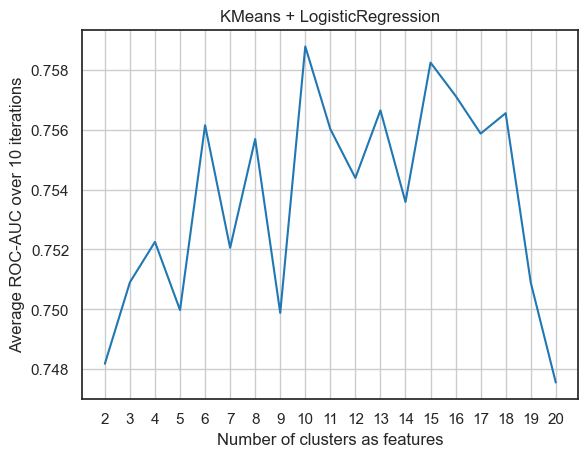

In [79]:
ax = plt.axes()
ax.plot(range(2, 21), roc_auc_list)
ax.set_xticks(range(2, 21))
ax.set(
    xticklabels= range(2, 21),
    xlabel='Number of clusters as features',
    ylabel='Average ROC-AUC over 10 iterations',
    title='KMeans + LogisticRegression'
)
ax.grid(True)

So there is a clear effect of adding a clustered feature column to the data. It may be hard to determine the clear best result from this since it will change every time we run the code above.

But it seems that the best perfomance consistenly lies around 10-15 clusters.